In [1]:
import os
import glob
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm, tqdm_notebook
import tools
%matplotlib notebook

### komentarji:
    
    - omejitev števila točk (urejeno glede na "moč" ujemanja)
    - log napak projekcije
    - boljša triangulacija!
    - unikaten identifier vsake matrike ``[R|t]`` (da niso naslavljane po indeksu)

In [2]:
SCALE = 0.25
MATCH_RATIO = 0.85  # more -> LESS matches rejected
FTOL = 1e-5         # cost function change tolerance for BA
NFEV = 5000         # maximum number of least_squares iterations
MODE = 'ORB'        # feature extraction algorithm
WEIGHT_CUTOFF = 50  # px

In [3]:
d_max = 2       # (for RANSAC) maximum distance from epipolar line above which a point is considered an outlier
alpha = 0.995   # (RANSAC) desired probability, that the estimated F matrix is correct
max_outlier_sd = 2

In [4]:
path = 'images/kip'
path_calib = 'kalibracija/redmi'
images = glob.glob(os.path.join(path, '*.JPG'))[1:-1]
calibration_images = glob.glob(os.path.join(path_calib, '*.JPG'))

### main loop

In [5]:
beginning_time = time.perf_counter()

In [6]:
scene = {}
K, distCoeffs = tools.calibrate_camera(calibration_images, (6, 4), (40, 40), scale=0.5)
N = len(images)

In [7]:
after_calibration = time.perf_counter()

--- BUNDLE ADJUSTMENT ---
parameters:	1977 
cost before BA:	4661.58
optimization summary:
	cost 2330.78830
	nfev 1979.00000
	status 2
	message `ftol` termination condition is satisfied.
cost after BA:	4661.58 



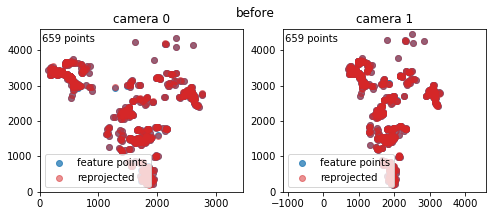

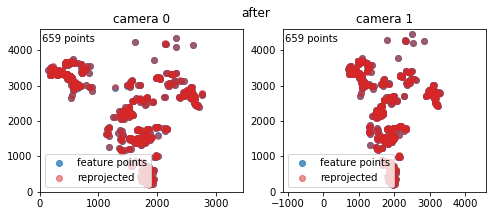

PnPRANSAC  271
--- BUNDLE ADJUSTMENT ---
parameters:	1578 
cost before BA:	11661.35
optimization summary:
	cost 5830.64475
	nfev 1580.00000
	status 2
	message `ftol` termination condition is satisfied.
cost after BA:	11661.29 



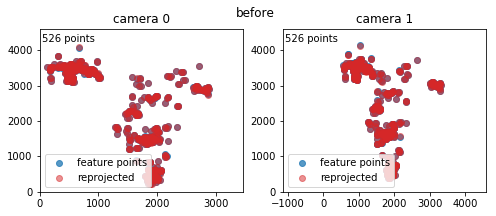

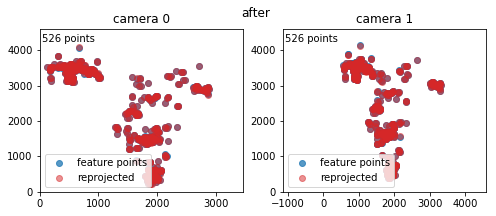

PnPRANSAC  219
--- BUNDLE ADJUSTMENT ---
parameters:	1488 
cost before BA:	947.27
optimization summary:
	cost 469.50781
	nfev 4468.00000
	status 2
	message `ftol` termination condition is satisfied.
cost after BA:	939.02 



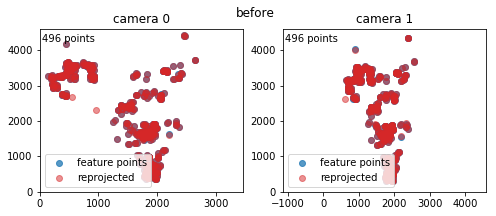

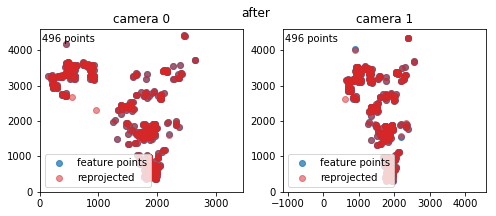

PnPRANSAC  280
--- BUNDLE ADJUSTMENT ---
parameters:	2166 
cost before BA:	48937.52
optimization summary:
	cost 24262.97024
	nfev 6502.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	48525.94 



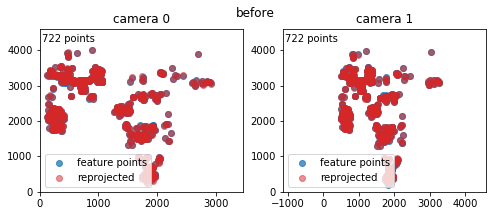

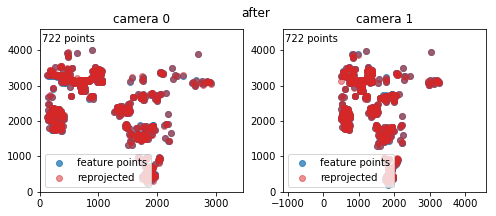

PnPRANSAC  319
--- BUNDLE ADJUSTMENT ---
parameters:	1662 
cost before BA:	22327.42
optimization summary:
	cost 6143.12697
	nfev 6653.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	12286.25 



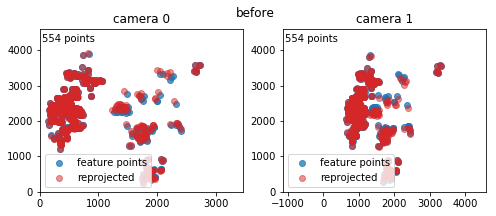

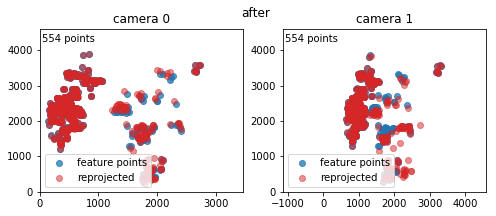

PnPRANSAC  135
--- BUNDLE ADJUSTMENT ---
parameters:	1128 
cost before BA:	25674.80
optimization summary:
	cost 7365.37137
	nfev 5646.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	14730.74 



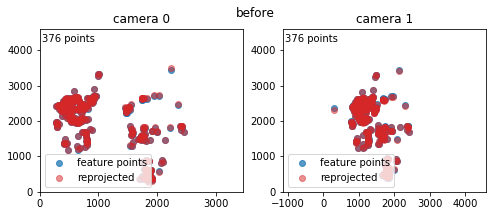

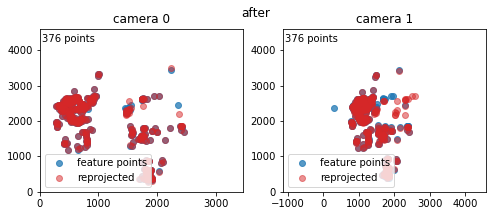

PnPRANSAC  152
--- BUNDLE ADJUSTMENT ---
parameters:	1725 
cost before BA:	50696.67
optimization summary:
	cost 11755.63908
	nfev 5179.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	23511.28 



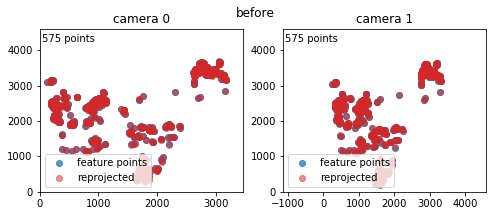

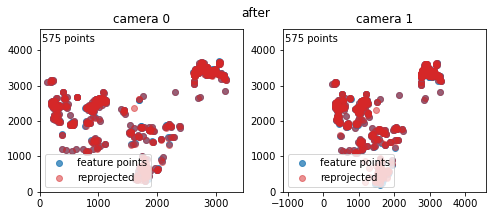

PnPRANSAC  140
--- BUNDLE ADJUSTMENT ---
parameters:	660 
cost before BA:	17193.46
optimization summary:
	cost 5603.60529
	nfev 5289.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	11207.21 



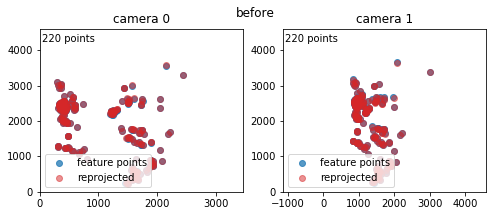

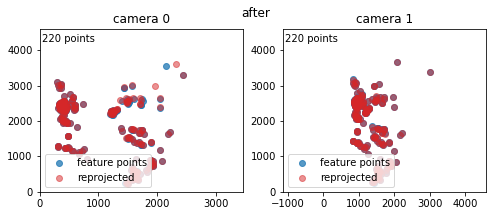

PnPRANSAC  66
--- BUNDLE ADJUSTMENT ---
parameters:	945 
cost before BA:	31130.47
optimization summary:
	cost 9149.39682
	nfev 5677.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	18298.79 



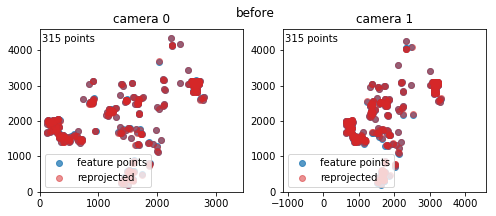

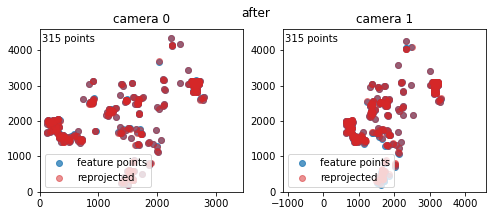

PnPRANSAC  112
--- BUNDLE ADJUSTMENT ---
parameters:	1974 
cost before BA:	8034.10
optimization summary:
	cost 4017.01394
	nfev 1976.00000
	status 2
	message `ftol` termination condition is satisfied.
cost after BA:	8034.03 



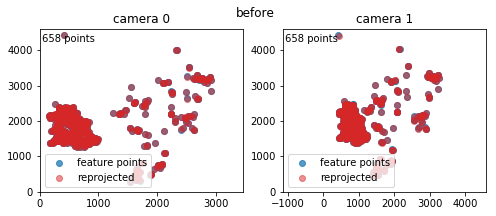

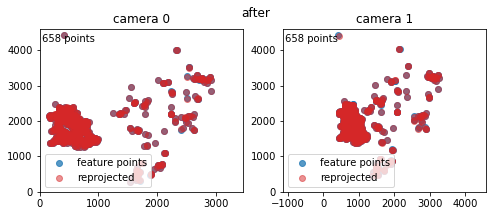

In [8]:
plot = False
%matplotlib inline

for i in tqdm_notebook(range(N - 1)):
    
    if i == 0:
        last_Rt = None
        im1 = tools.read_bw(images[i])
        im2 = tools.read_bw(images[i+1])
        Rt1, Rt2, p1, p2 = tools.get_camera_matrices(im1, im2, K, last_Rt, optimize=True, d_max=d_max, alpha=alpha,
                                           scale=SCALE, match_ratio=MATCH_RATIO, mode=MODE)
    else:
        im1 = im2
        im2 = tools.read_bw(images[i+1])
        Rt1, Rt2, p1, p2 = tools.get_camera_matrices_PnP(im1, im2, K, last_Rt, cloud, i, distCoeffs, 
                                            d_max=d_max, alpha=alpha, scale=SCALE, match_ratio=MATCH_RATIO, mode=MODE)

    last_Rt = Rt2
    P1 = K.dot(Rt1)
    P2 = K.dot(Rt2)
    
    points3D = []
    for x1, x2 in zip(p1, p2):
        X = tools.triangulate_lm(tools.to_homogenous(x1), tools.to_homogenous(x2), P1, P2)
        points3D.append(tools.Point3D(X, x1, x2, i, i+1))
    
    if i == 0:
        cloud = tools.Scene([Rt1, Rt2], points3D, K, im1.shape, debug=True)
        cloud.bundle_adjustment(ftol=FTOL, max_nfev=NFEV, max_sd_dist=max_outlier_sd, 
                                weight_cutoff=WEIGHT_CUTOFF, X_only=True)
    else:
        pair = tools.Scene([Rt1, Rt2], points3D, K, im1.shape, frame_offset=i, debug=True)
        pair.bundle_adjustment(ftol=FTOL, max_nfev=NFEV, max_sd_dist=max_outlier_sd, 
                               weight_cutoff=WEIGHT_CUTOFF, X_only=True)
        cloud.add_next_pair(pair)
        
#         # Sequential bundle adjustment
#         print('\n--- seqential BA, image pair {:d} ---'.format(i))
#         cloud.bundle_adjustment(ftol=FTOL, max_nfev=NFEV, max_sd_dist=max_outlier_sd, X_only=True)
        
    if plot:# and i % (N//2) == 0:
        print('---- slika {:d} ----\n'.format((i+1)))
        cloud.render()
        
        fig, ax = plt.subplots(1, 2, figsize=(10, 3))
        ax[0].imshow(im1, cmap='gray')
        ax[0].scatter(p1[:, 0], p1[:, 1])
        ax[1].imshow(im2, cmap='gray')
        ax[1].scatter(p2[:, 0], p2[:, 1])
        plt.show()

In [9]:
main_loop_time = time.perf_counter()

In [10]:
#X, Y, Z = cloud.render()

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


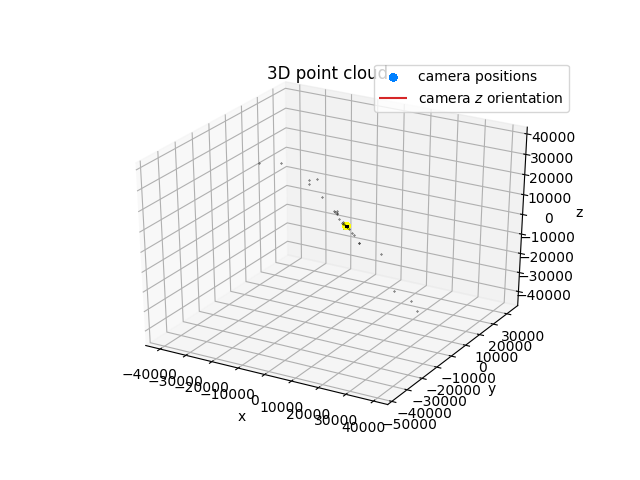

4478 identified points (4478 shown).


In [11]:
%matplotlib
X, Y, Z = cloud.render(cameras=True)

In [12]:
# cloud.bundle_adjustment(ftol=1e-3, max_nfev=5000, X_only=True)

In [13]:
end_time = time.perf_counter()

In [14]:
total = end_time - beginning_time 
calibration = after_calibration - beginning_time
loop = main_loop_time - after_calibration
ba = end_time - main_loop_time
print('total time:\t{:.0f} min {:.1f} s'.format(total // 60, total % 60))
print('calib. time:\t{:.0f} min {:.1f} s'.format(loop // 60, calibration % 60))
print('loop time:\t{:.0f} min {:.1f} s'.format(loop // 60, loop % 60))
print('ba time:\t{:.0f} min {:.1f} s'.format(ba // 60, ba % 60))

total time:	2 min 57.1 s
calib. time:	2 min 1.2 s
loop time:	2 min 55.6 s
ba time:	0 min 0.2 s


In [15]:
name = path.replace('/', '_').replace('\\', 'n')
name += '_pairwise_BA_x_only'
cloud.pickle_save(name=name, path='results', mode='scene')

Saved scene to: results\scene_images_kip_pairwise_BA_x_only_06-09-15-22.pkl
